<a href="https://colab.research.google.com/github/sourcecode369/Kaggle-Notebooks/blob/master/Supervised%20Contrastive%20Learning/Supervised_Contrastive_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchtoolbox
!pip install pretrainedmodels

     |████████████████████████████████| 61kB 3.7MB/s 


In [ ]:
import math
import time
import torch
from tqdm import tqdm
import torch.nn as nn
import pretrainedmodels
import torch.nn.functional as F
import torchtoolbox
from torchvision import datasets, transforms
from torchtoolbox.optimizer import Lookahead

import warnings
warnings.simplefilter("ignore")

In [ ]:
class SupConNetwork(nn.Module):
    def __init__(self, name='resnet18', head='mlp', feat_dim=2048):
        super(SupConNetwork, self).__init__()
        self.arch = pretrainedmodels.__dict__[name](pretrained='imagenet')
        if head == 'linear':
            self.arch.last_linear = nn.Sequential(nn.Linear(self.arch.last_linear.in_features, feat_dim))
        elif head == 'mlp':
            self.arch.last_linear = nn.Sequential(nn.Linear(self.arch.last_linear.in_features, self.arch.last_linear.in_features),
                                                  nn.ReLU(),
                                                  nn.Linear(self.arch.last_linear.in_features, feat_dim))
        else:
            raise NotImplementedError('Head not Supported {}'.format(head))
    
    def forward(self, image):
        return F.normalize(self.arch(image), dim=1)

In [ ]:
class TwoCropTransform:
    """Create two crops of the same image"""
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x)]

In [ ]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
normalize = transforms.Normalize(mean=mean, std=std)

train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        normalize,
])
train_dataset = datasets.CIFAR10(root='./data',
                                transform=TwoCropTransform(train_transform),
                                 train=True,
                                 download=True)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified


In [ ]:
class AverageMeter:
    """
    Computes and stores the average and current value
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [ ]:
def adjust_learning_rate(args, optimizer, epoch):
    lr = args["learning_rate"]
    if args["cosine"]:
        eta_min = lr * (args["lr_decay_rate"] ** 3)
        lr = eta_min + (lr - eta_min) * (
                1 + math.cos(math.pi * epoch / args["epochs"])) / 2
    else:
        steps = np.sum(epoch > np.asarray(args["lr_decay_epochs"]))
        if steps > 0:
            lr = lr * (args["lr_decay_rate"] ** steps)

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
model = SupConNetwork()
model.cuda()

criterion = SupConLoss(temperature=0.07)
criterion.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
optimizer = Lookahead(optimizer)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=3,threshold=0.001, mode="max")

In [ ]:
arguments = {'epochs':100,
             'learning_rate':0.05,
             'lr_decay_rate':0.1,
             'lr_decay_epochs':'70,80,90',
             'weight_decay':1e-4,
             'momentum':0.9,
             'temperature':0.07,
             'cosine':True,
             'warm':True,
             'syncBN':True
             }

In [ ]:
for epoch in range(arguments['epochs']):
    adjust_learning_rate(arguments, optimizer, epoch)
    time1 = time.time()
    model.train()
    losses = AverageMeter()
    tk = tqdm(trainloader, total=len(trainloader), position=0, leave=True)
    for idx, (images, labels) in enumerate(tk):
        images = torch.cat([images[0], images[1]], dim=0)
        images = torch.tensor(images, device="cuda", dtype=torch.float32)
        labels = torch.tensor(labels, device="cuda", dtype=torch.float32)
        bsz = labels.shape[0]
        
        features = model(images)
        f1, f2 = torch.split(features, [bsz, bsz], dim=0)
        features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
        
        loss = criterion(features, labels)
        losses.update(loss.item(), bsz)
        
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step() 

        tk.set_postfix(loss=losses.avg)
  
    time2 = time.time()
    print('epoch {}, total time {:.2f}'.format(epoch, time2 - time1))        

  0%|          | 0/782 [00:00<?, ?it/s]

epoch 0, total time 252.03


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 1, total time 251.00


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 2, total time 251.09


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 3, total time 253.04


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 4, total time 251.63


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 5, total time 250.76


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 6, total time 250.96


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 7, total time 253.03


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 8, total time 251.65


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 9, total time 250.81


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 10, total time 250.97


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 11, total time 253.06


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 12, total time 251.71


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 13, total time 250.72


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 14, total time 250.91


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 15, total time 252.91


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 16, total time 251.60


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 17, total time 250.90


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 18, total time 251.04


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 19, total time 253.23


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 20, total time 251.53


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 21, total time 250.74


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 22, total time 250.86


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 23, total time 252.77


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 24, total time 251.54


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 25, total time 250.77


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 26, total time 250.90


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 27, total time 252.75


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 28, total time 251.57


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 29, total time 250.62


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 30, total time 250.85


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 31, total time 252.48


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 32, total time 251.31


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 33, total time 250.65


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 34, total time 250.96


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 35, total time 252.68


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 36, total time 251.61


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 37, total time 250.73


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 38, total time 250.94


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 39, total time 253.03


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 40, total time 251.65


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 41, total time 250.68


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 42, total time 250.84


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 43, total time 252.65


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 44, total time 251.55


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 45, total time 250.76


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 46, total time 250.97


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 47, total time 252.98


 18%|█▊        | 144/782 [00:46<03:24,  3.12it/s, loss=3.33]

KeyboardInterrupt: ignored

In [ ]:
images = torch.tensor(images, device="cuda", dtype=torch.float32)
labels = torch.tensor(labels, device="cuda", dtype=torch.float32)
features = model(images)
f1, f2 = torch.split(features, [bsz, bsz], dim=0)
features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)

In [ ]:
features.shape

torch.Size([64, 2, 2048])

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2, init='pca', n_iter=1000, random_state=2020, perplexity=40).fit_transform(features[:,0,:].cpu().detach().numpy().squeeze())

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

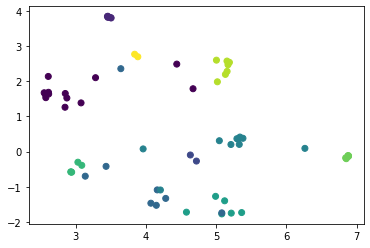

In [ ]:
plt.scatter(tsne[:,0], tsne[:,1], c=labels.cpu().detach().numpy())